In [80]:
import pandas as pd
import datetime
import requests
import io
from day_trade import login_webull
from scipy.signal import find_peaks
import matplotlib
import mplfinance as fplt
import os
from os import listdir
from shutil import copyfile
import random

matplotlib.use('agg')

In [7]:
wb = login_webull('mcian91@email.com')

In [13]:
timeframe = '1'
period = '1'
date = pd.Timestamp('2021-02-02', tz='America/New_York')
end_date = pd.Timestamp('2021-02-19', tz='America/New_York')
hists = {}

while date < end_date:
    next_day = date + datetime.timedelta(hours=24)
    next_date_str = next_day.isoformat()[:10]
    csv_file = f'swing_trade/Lizard Bullish-{date.isoformat()[:10]}.csv'
    print(csv_file)
    stocks = pd.read_csv(csv_file)
    for symbol in stocks['symbol']:
        print(symbol)
        filename = f'{symbol}_{next_date_str}'
        try:
            alpha_url = f"https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol={symbol}&interval=1min&slice=year1month1&apikey=M6HNQZFS7S470HMZ&datatype=csv"
            r = requests.get(alpha_url)
            hist = pd.read_csv(io.StringIO(r.content.decode('utf-8')))
            hist['time'] = pd.to_datetime(hist['time'])
            hist = hist[[next_date_str in time for time in hist['time']]].sort_values('time').set_index('time')
        except KeyError:
            try:
                hist = wb.get_bars(stock=symbol.upper(), interval='m'+timeframe, count=int((390*int(period))/int(timeframe)), 
                                   extendTrading=0, timeStamp=int((next_day + datetime.timedelta(hours=24)).timestamp()))
            except ValueError:
                print(f"Couldn't find {symbol}")
            hist = pd.DataFrame(hist)
            hist = hist[[next_date_str in idx.isoformat() for idx in hist.index]]
            
        peaks, peak_prop = find_peaks(hist['close'], width=1, prominence=(0.02, None))
        valleys, valley_prop = find_peaks(hist['close']*(-1), width=2.5, prominence=(0.05, None), plateau_size=(0,1))
        hist['label'] = ['sell' if idx in peaks else 'buy' if idx in valleys else 'nothing' for idx in range(len(hist))]
        hist.to_csv(f'daily_stock_data/{filename}.csv')
        hists[filename] = hist
        
    if date.day_of_week in range(1,3):
        date += datetime.timedelta(hours=24)
    elif date.day_of_week == 3:
        date += datetime.timedelta(hours=24*5)
    else:
        print("shouldn't be here")
        break

swing_trade/Lizard Bullish-2021-02-02.csv
AVDL
BTG
CXP
OBLG
swing_trade/Lizard Bullish-2021-02-03.csv
NXGN
TATT
DSKE
GIX
swing_trade/Lizard Bullish-2021-02-04.csv
VBLT
DGNR
swing_trade/Lizard Bullish-2021-02-09.csv
ISUN
LBRT
swing_trade/Lizard Bullish-2021-02-10.csv
UONE
VTGN
swing_trade/Lizard Bullish-2021-02-11.csv
BTAQ
FCAC
swing_trade/Lizard Bullish-2021-02-16.csv
swing_trade/Lizard Bullish-2021-02-17.csv
ADTN
DGLY
OIIM
ACER
GNW
MBI
UGP
DARE
HCHC
WTRH
JNCE
ARLO
RSI
FURY
ROOT
GMIIU
swing_trade/Lizard Bullish-2021-02-18.csv
SRGA
MWA
CFMS
HTOO
FLUX
ACAC
KRNLU


In [ ]:
for f, hist in hists.items():
    hist.to_csv(f'./day_trader_bot/daily_stock_data/{f}.csv')

In [17]:
hists = {}
path = './daily_stock_data/'
for file in [f for f in listdir(path) if f.endswith('.csv')]:
    try:
        hists[file[:-4]] = pd.read_csv(path+file, index_col='timestamp')
        hists[file[:-4]].index = pd.to_datetime(hists[file[:-4]].index)
    except:
        try:
            hists[file[:-4]] = pd.read_csv(path+file, index_col='time')
            hists[file[:-4]].index = pd.to_datetime(hists[file[:-4]].index)
        except:
            pass

In [119]:
mc = fplt.make_marketcolors(
                        up='tab:blue',down='tab:red',
                        edge='black',
                        wick={'up':'blue','down':'red'},
                        volume='green',
                       )

s  = fplt.make_mpf_style(marketcolors=mc, mavcolors=["yellow","orange",'brown'])

hist = hists['ACAC_2021-02-19']
i = 38
fig = fplt.plot(
    hist.iloc[i:i+45],
    type='candle',
    style=s,
    volume=True,
    axisoff=True,
    mav=(5,8,13),
    figsize=(3.2,3.2),
    xlim=(13, 45),
    savefig=f'./stock_graphs/test.jpeg',
    returnfig=True,
    tight_layout=True
)

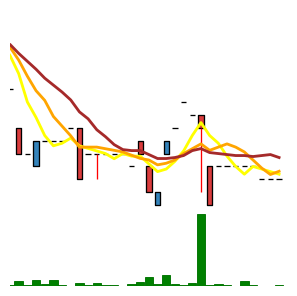

In [120]:
fig[0]

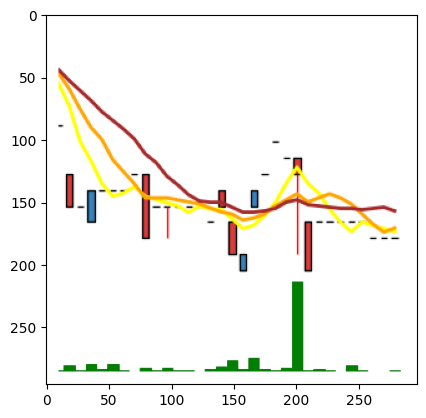

In [121]:
from matplotlib import image
from matplotlib import pyplot as plt
i = image.imread(f'stock_graphs/test.jpeg')
plt.imshow(i)

In [69]:
i.shape

(320, 320, 3)

In [78]:
mc = fplt.make_marketcolors(
                        up='tab:blue',down='tab:red',
                        edge='black',
                        wick={'up':'blue','down':'red'},
                        volume='green',
                       )

s  = fplt.make_mpf_style(marketcolors=mc, mavcolors=["yellow","orange",'brown'])

for filename, hist in hists.items():
    print(filename)
    if not os.path.exists(f'./stock_graphs/{filename}/'):
        os.makedirs(f'./stock_graphs/{filename}/')
    for i in range(13,len(hist)-45):
        fplt.plot(
            hist.iloc[i:i+45],
            type='candle',
            style=s,
            volume=True,
            axisoff=True,
            mav=(5,8,13),
            figsize=(3.2,3.2),
            xlim=(13, 45),
            savefig=f'./stock_graphs/{filename}/{filename}_{i}.jpeg',
            tight_layout=True
        )

ACAC_2021-02-19
ACER_2021-02-18
ADTN_2021-02-18
ARLO_2021-02-18
AUPH_2021-02-05
AVDL_2021-02-03
BTAQ_2021-02-12
BTG_2021-02-03
CFMS_2021-02-19
CXP_2021-02-03
DARE_2021-02-18
DGLY_2021-02-18
DGNR_2021-02-05
DSKE_2021-02-04
FCAC_2021-02-12
FLUX_2021-02-19
FURY_2021-02-18
GIX_2021-02-04
GMIIU_2021-02-18


c:\users\mcian\appdata\local\programs\python\python37\lib\site-packages\mplfinance\plotting.py:421: UserWarning: Attempting to set identical bottom == top == 11.05 results in singular transformations; automatically expanding.
  axA1.set_ylim(config['ylim'][0], config['ylim'][1])
c:\users\mcian\appdata\local\programs\python\python37\lib\site-packages\mplfinance\plotting.py:421: UserWarning: Attempting to set identical bottom == top == 11.05 results in singular transformations; automatically expanding.
  axA1.set_ylim(config['ylim'][0], config['ylim'][1])
c:\users\mcian\appdata\local\programs\python\python37\lib\site-packages\mplfinance\plotting.py:421: UserWarning: Attempting to set identical bottom == top == 11.05 results in singular transformations; automatically expanding.
  axA1.set_ylim(config['ylim'][0], config['ylim'][1])
c:\users\mcian\appdata\local\programs\python\python37\lib\site-packages\mplfinance\plotting.py:421: UserWarning: Attempting to set identical bottom == top == 11

GNW_2021-02-18
GXGX_2021-02-12
HCHC_2021-02-18
HTOO_2021-02-19
ISUN_2021-02-10
JNCE_2021-02-18
KRNLU_2021-02-19


c:\users\mcian\appdata\local\programs\python\python37\lib\site-packages\mplfinance\plotting.py:421: UserWarning: Attempting to set identical bottom == top == 10.45 results in singular transformations; automatically expanding.
  axA1.set_ylim(config['ylim'][0], config['ylim'][1])
c:\users\mcian\appdata\local\programs\python\python37\lib\site-packages\mplfinance\plotting.py:421: UserWarning: Attempting to set identical bottom == top == 10.45 results in singular transformations; automatically expanding.
  axA1.set_ylim(config['ylim'][0], config['ylim'][1])
c:\users\mcian\appdata\local\programs\python\python37\lib\site-packages\mplfinance\plotting.py:421: UserWarning: Attempting to set identical bottom == top == 10.45 results in singular transformations; automatically expanding.
  axA1.set_ylim(config['ylim'][0], config['ylim'][1])
c:\users\mcian\appdata\local\programs\python\python37\lib\site-packages\mplfinance\plotting.py:421: UserWarning: Attempting to set identical bottom == top == 10

LBRT_2021-02-10
MBI_2021-02-18
MWA_2021-02-19
NXGN_2021-02-04
OBLG_2021-02-03
OIIM_2021-02-18
ROOT_2021-02-18
RSI_2021-02-18
SRGA_2021-02-19
TATT_2021-02-04
UGP_2021-02-18
UONE_2021-02-11
VBLT_2021-02-05
VTGN_2021-02-11
WTRH_2021-02-18


In [90]:
hist['label'].value_counts()

nothing    271
sell        15
buy          3
Name: label, dtype: int64

In [95]:
counts = {}
for filename, hist in hists.items():
    print(filename)
    for i in range(13,len(hist)-45):
        f = f'./stock_graphs/{filename}/{filename}_{i}.jpeg'
        try:
            if image.imread(f).shape != (320, 320, 3):
                os.remove(f)
                continue
        except:
            continue
        label = hist.iloc[i+45-1]['label']
        date = filename.split('_')[1]
        if date == '2021-02-19':
            folder = 'test'
            if not os.path.exists(f'./stock_graphs/{folder}/'):
                os.makedirs(f'./stock_graphs/{folder}/')
            for b in ['buy', 'sell', 'nothing']:
                if not os.path.exists(f'./stock_graphs/{folder}/{b}/'):
                    os.makedirs(f'./stock_graphs/{folder}/{b}/')
        elif random.uniform(0, 1) < 0.2:
            folder = 'val'
            if not os.path.exists(f'./stock_graphs/{folder}/'):
                os.makedirs(f'./stock_graphs/{folder}/')
            for b in ['buy', 'sell', 'nothing']:
                if not os.path.exists(f'./stock_graphs/{folder}/{b}/'):
                    os.makedirs(f'./stock_graphs/{folder}/{b}/')
        else:
            folder = 'train'
            if not os.path.exists(f'./stock_graphs/{folder}/'):
                os.makedirs(f'./stock_graphs/{folder}/')
            for b in ['buy', 'sell', 'nothing']:
                if not os.path.exists(f'./stock_graphs/{folder}/{b}/'):
                    os.makedirs(f'./stock_graphs/{folder}/{b}/')
                    
        try:
            copyfile(f, f'./stock_graphs/{folder}/{label}/{filename}_{i}.jpeg')
        except Exception as e:
            print(e)
            
    counts[folder] = hist.iloc[13:-45]['label'].value_counts()

ACAC_2021-02-19
ACER_2021-02-18
ADTN_2021-02-18
ARLO_2021-02-18
AUPH_2021-02-05
AVDL_2021-02-03
BTAQ_2021-02-12
BTG_2021-02-03
CFMS_2021-02-19
CXP_2021-02-03
DARE_2021-02-18
DGLY_2021-02-18
DGNR_2021-02-05
DSKE_2021-02-04
FCAC_2021-02-12
FLUX_2021-02-19
FURY_2021-02-18
GIX_2021-02-04
GMIIU_2021-02-18
GNW_2021-02-18
GXGX_2021-02-12
HCHC_2021-02-18
HTOO_2021-02-19
ISUN_2021-02-10
JNCE_2021-02-18
KRNLU_2021-02-19
LBRT_2021-02-10
MBI_2021-02-18
MWA_2021-02-19
NXGN_2021-02-04
OBLG_2021-02-03
OIIM_2021-02-18
ROOT_2021-02-18
RSI_2021-02-18
SRGA_2021-02-19
TATT_2021-02-04
UGP_2021-02-18
UONE_2021-02-11
VBLT_2021-02-05
VTGN_2021-02-11
WTRH_2021-02-18


In [96]:
counts

{'test': Series([], Name: label, dtype: int64),
 'train': nothing    217
 sell        12
 buy          2
 Name: label, dtype: int64,
 'val': nothing    104
 sell         4
 buy          1
 Name: label, dtype: int64}

In [ ]:
for t in ['train', 'test']:
    for p in ['buy', 'sell', 'nothing']:
        path = f'stock_graphs/train/{p}/'
        for file in [f for f in listdir(path)]:
            train_x.append(image.imread(path+file))
            train_y.append(p)